<a href="https://colab.research.google.com/github/wizard339/education/blob/main/classification_pytorch_mnist__1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация датасета MNIST с помощью PyTorch Lightning.

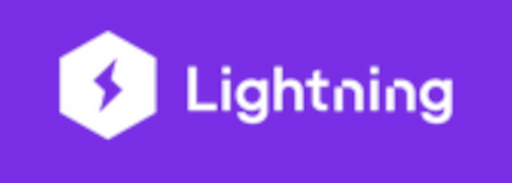

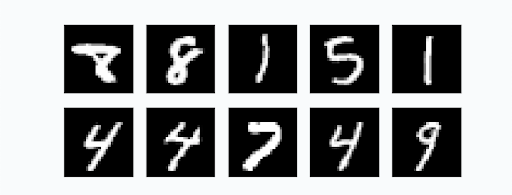

In [1]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 800 kB 6.5 MB/s 
     |████████████████████████████████| 512 kB 44.2 MB/s 
     |████████████████████████████████| 125 kB 57.2 MB/s 


In [10]:
import os

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split

from torchvision import datasets, transforms
from torchvision.datasets import MNIST

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

ModuleNotFoundError: ignored

In [3]:
# Путь, куда сохранять параметры модели.
# Можно примонтировать Google Drive для сохранения результатов.
# Результаты останутся на Google Drive, если в Colab произойдет отключение от среды исполнения.
MODEL_PATH='drive/My Drive/classification_pytorch_mnist'

In [8]:
def prepare_data():
    """
    Скачать датасет и создать обучающую, валидационную и тестовую выборки.
    """
    transform=transforms.Compose([
            transforms.ToTensor(),
            # Иногда встречается рекомендация нормализовывать MNIST с такими значениями среднего и стандартного отклонения.
            transforms.Normalize((0.1307,), (0.3081,))
    ])

    train = MNIST(os.getcwd(), train=True, download=True, transform=transform)
    train = [train[i] for i in range(2200)]

    train, val = random_split(train, [2000, 200])

    test = MNIST(os.getcwd(), train=False, download=True, transform=transform)
    test = [test[i] for i in range(3000,4000)]

    return train, val, test

In [6]:
class LightningMnistClassifier(pl.LightningModule):
    """
    Классификатор датасета MNIST с помощью PyTorch Lightning.
    """

    def __init__(self, lr_rate):
        super(LightningMnistClassifier, self).__init__()

        self.layer_1 = torch.nn.Linear(28 * 28, 128)
        self.layer_2 = torch.nn.Linear(128, 256)
        self.layer_3 = torch.nn.Linear(256, 10)
        self.lr_rate = lr_rate

    def forward(self, x):
        batch_size, channels, width, height = x.size()

        # (batch_size, 1, 28, 28) -> (batch_size, 1*28*28)
        x = x.view(batch_size, -1)

        # Каждый следующий слой выводит больше признаков.
        x = self.layer_1(x)
        x = torch.relu(x)

        # Каждый следующий слой выводит больше признаков.
        x = self.layer_2(x)
        x = torch.relu(x)

        # Определяет влияние признаков на вероятности принадлежности к определённому классу.
        x = self.layer_3(x)
        x = torch.softmax(x, dim=1)

        return x

    def cross_entropy_loss(self, logits, labels):
        return F.nll_loss(logits, labels)

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('train_loss', loss)

        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('val_loss', loss)

        logs = {'val_loss': loss}
        return {'val_loss': loss, 'log': logs}

    def test_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        return {'test_loss': loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        tensorboard_logs = {'test_loss': avg_loss}
        return {'avg_test_loss': avg_loss, 'log': tensorboard_logs}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr_rate)
        lr_scheduler = {'scheduler': torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95),
                        'name': 'expo_lr'}
        return [optimizer], [lr_scheduler]

In [11]:
train, val, test = prepare_data()

In [8]:
train_loader, val_loader, test_loader = DataLoader(train, batch_size=64), DataLoader(val, batch_size=64), DataLoader(test, batch_size=64)

In [11]:
model = LightningMnistClassifier(lr_rate=1e-3)

# Автоматическое досрочное прекращение процесса обучения если заданная метрика качества не уменьшается заданное время.
early_stopping = EarlyStopping('val_loss', mode='min', patience=5)
# Callback для сheckpoint'а после эпохи обучения с локальным минимумом или максимумом метрики качества.
checkpoint_callback = ModelCheckpoint(dirpath=MODEL_PATH, filename='{epoch}-{val_loss:.2f}',
                                      monitor='val_loss', mode='min', save_top_k=3)

trainer = pl.Trainer(max_epochs=30, profiler='pytorch',
                     callbacks=checkpoint_callback,
                     default_root_dir=MODEL_PATH)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 2.6 K 
-----------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params
0.544     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO:pytorch_lightning.profilers.profiler:FIT Profiler Report
Profile stats for: records
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*        14.55%       3.423ms        99.88%      23.497ms      11.748ms             2  
[pl][profile][Callback]TQDMProgressBar.on_validation...        48.53%      11.418ms        48.54%      11.419ms       5.710ms             2  
[pl][profile][Strategy]SingleDeviceStrategy.validati...        13.42%       3.158ms        23.60%       5.552m

In [14]:
trainer.test(dataloaders=test_loader, ckpt_path=None)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:134: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/My Drive/classification_pytorch_mnist/epoch=18-val_loss=-0.84.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/drive/My Drive/classification_pytorch_mnist/epoch=18-val_loss=-0.84.ckpt


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.profilers.profiler:TEST Profiler Report
Profile stats for: records
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*        24.73%       6.330ms        99.86%      25.561ms       8.520ms             3  
[pl][profile][Callback]TQDMProgressBar.on_test_batch...        41.69%      10.670ms        41.70%      10.673ms       3.558ms             3  
[pl][profile][Strategy]SingleDeviceStrategy.test_ste...         4.05%       1.036ms        18.34%       4.695ms       1.565ms             3  
                                           aten::linear   

[{}]

torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])
Предсказанное значение :  [8]
Реальное значение :  8


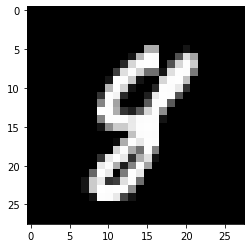

In [15]:
import numpy as np

test_pixels = test[12][0]
actual_label = test[12][1]

print(test_pixels.shape)

# Добавляем ещё одно измерение - batch size.
input = test_pixels.unsqueeze(1)

print(input.shape)

predictions = model(input)
print('Предсказанное значение : ', np.argmax(predictions.detach().numpy(), axis=1))
print('Реальное значение : ', actual_label)


import matplotlib.pyplot as plt

# Reshape - разворачиваем измерение, соответствующее каналам изображения (1 канал - оттенки серого).
plt.imshow(test_pixels.reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()

# Классификация датасета MNIST с помощью PyTorch Ignite.

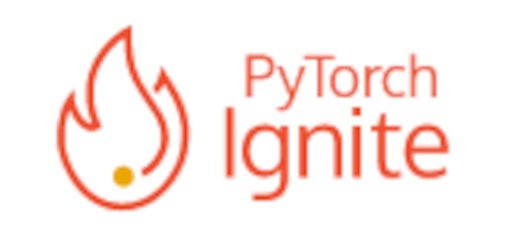

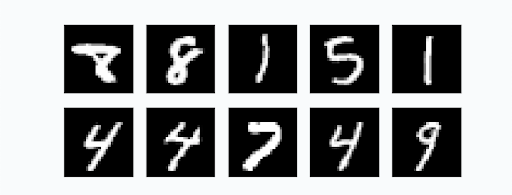

In [1]:
!pip install pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 264 kB 11.0 MB/s 


In [2]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import SGD
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Normalize, ToTensor

from tqdm import tqdm

from ignite.engine import Events, create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import Accuracy, Loss
from ignite.utils import setup_logger

In [3]:
class IgniteMnistClassifier(nn.Module):
    """
    Классификатор датасета MNIST с помощью PyTorch Ignite.
    """

    def __init__(self):
        super(IgniteMnistClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

In [4]:
def get_data_loaders(train_batch_size, val_batch_size):
    """
    Скачать датасет и создать обучающую и валидационную выборки.
    """

    data_transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

    train_loader = DataLoader(
        MNIST(download=True, root=".", transform=data_transform, train=True), batch_size=train_batch_size, shuffle=True
    )

    val_loader = DataLoader(
        MNIST(download=False, root=".", transform=data_transform, train=False), batch_size=val_batch_size, shuffle=False
    )

    return train_loader, val_loader

In [5]:
from torch.nn import Module

# Запуск обучения и валидации.
# Разработчик модели должен написать подобный метод.
# За ним остаётся декомпозиция этого метода на вложенные методы, вынесение логики во вспомогательные классы и т.п.
# Ignite предоставляет только событийный механизм.
# Ignite в меньшей степени диктует организацию кода. У такого подхода есть и положительные, и отрицательные стороны.
def create_and_train_model(train_batch_size, val_batch_size, epochs, lr, momentum, log_interval) -> Module:
    """
    Создать и обучить модель.

    :return: обученная модель
    :rtype: torch.nn.Module
    """

    train_loader, val_loader = get_data_loaders(train_batch_size, val_batch_size)
    model = IgniteMnistClassifier()

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"

    model.to(device)
    optimizer = SGD(model.parameters(), lr=lr, momentum=momentum)
    criterion = nn.NLLLoss()
    trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
    trainer.logger = setup_logger("trainer")

    val_metrics = {"accuracy": Accuracy(), "nll": Loss(criterion)}
    evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)
    evaluator.logger = setup_logger("evaluator")

    # Например, можем сами добавить progress bar.
    progress_bar = tqdm(initial=0, leave=False, total=len(train_loader), desc=f"ITERATION - loss: {0:.2f}")
    with progress_bar:
        trainer.run(train_loader, max_epochs=epochs)

    return model


    # Вложенные методы для привязки к событиям.

    @trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
    def log_training_loss(engine):
        progress_bar.desc = f"ITERATION - loss: {engine.state.output:.2f}"
        progress_bar.update(log_interval)

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(engine):
        progress_bar.refresh()
        evaluator.run(train_loader)
        metrics = evaluator.state.metrics
        avg_accuracy = metrics["accuracy"]
        avg_nll = metrics["nll"]
        tqdm.write(
            f"Training Results - Epoch: {engine.state.epoch} Avg accuracy: {avg_accuracy:.2f} Avg loss: {avg_nll:.2f}"
        )

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_validation_results(engine):
        evaluator.run(val_loader)
        metrics = evaluator.state.metrics
        avg_accuracy = metrics["accuracy"]
        avg_nll = metrics["nll"]
        tqdm.write(
            f"Validation Results - Epoch: {engine.state.epoch} Avg accuracy: {avg_accuracy:.2f} Avg loss: {avg_nll:.2f}"
        )

        progress_bar.n = progress_bar.last_print_n = 0

    @trainer.on(Events.EPOCH_COMPLETED | Events.COMPLETED)
    def log_time(engine):
        tqdm.write(f"{trainer.last_event_name.name} took { trainer.state.times[trainer.last_event_name.name]} seconds")

In [6]:
# Запуск.
model = create_and_train_model(train_batch_size=32, val_batch_size=32, epochs=50, lr=0.01, momentum=0.5, log_interval=10)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



ITERATION - loss: 0.00:   0%|          | 0/1875 [00:00<?, ?it/s]2022-12-26 19:41:57,772 trainer INFO: Engine run starting with max_epochs=50.
2022-12-26 19:42:17,663 trainer INFO: Epoch[1] Complete. Time taken: 00:00:19.884
2022-12-26 19:42:31,936 trainer INFO: Epoch[2] Complete. Time taken: 00:00:14.272
2022-12-26 19:42:45,477 trainer INFO: Epoch[3] Complete. Time taken: 00:00:13.539
2022-12-26 19:42:59,045 trainer INFO: Epoch[4] Complete. Time taken: 00:00:13.566
2022-12-26 19:43:12,784 trainer INFO: Epoch[5] Complete. Time taken: 00:00:13.738
2022-12-26 19:43:26,133 trainer INFO: Epoch[6] Complete. Time taken: 00:00:13.348
2022-12-26 19:43:39,649 trainer INFO: Epoch[7] Complete. Time taken: 00:00:13.515
2022-12-26 19:43:53,110 trainer INFO: Epoch[8] Complete. Time taken: 00:00:13.460
2022-12-26 19:44:06,969 trainer INFO: Epoch[9] Complete. Time taken: 00:00:13.857
2022-12-26 19:44:20,536 trainer INFO: Epoch[10] Complete. Time taken: 00:00:13.566
2022-12-26 19:44:34,401 trainer INFO:

In [ ]:
import numpy as np

test_pixels = test[15][0]
actual_label = test[15][1]

# Добавляем ещё одно измерение - batch size.
input = test_pixels.unsqueeze(1)

predictions = model(input)
print('Предсказанное значение : ', np.argmax(predictions.detach().numpy(), axis=1))
print('Реальное : ', actual_label)


import matplotlib.pyplot as plt

# Reshape - разворачиваем измерение, соответствующее каналам изображения (1 канал - оттенки серого).
plt.imshow(test_pixels.reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()